In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.linalg import block_diag
from scipy import linalg
import control
import matplotlib.colors as colors
from matplotlib import style
from matplotlib.patches import Rectangle
from numpy.linalg import matrix_power
import cvxpy as cp

In [2]:
# finding the value of Gamma_k, a helper
def Gamma(F,G,K,k):
    n=F.shape[0]
    Gamma_k = np.zeros([n, n])
    for h in range(k+1):
        Gamma_k += matrix_power(F-G@K,h)@G@K@matrix_power(F-G@K,k-h)
    return -Gamma_k

In [3]:
# finding the value of x_0' at any k
def xk_prime(F_K,k,x_0_prime):
    xk_prime = matrix_power(F_K,k)@x_0_prime
    return xk_prime
    # finding the mean value of x_0'' at any k
    
def bar_xk_Dprime(F_K,k,x_0_Dprime,x_0_prime):
    bar_x_Dprime = matrix_power(F_K,k)@x_0_Dprime + Gamma(F,G,K,k-1)@x_0_prime
    return bar_x_Dprime

In [4]:
# calculating constant values \mathcal A1, A2 of J_c(x_0')
def A1_and_A2(F,G,K,Q,R,N):
    A1 = Gamma(F,G,K,N-1).T @ Q @ Gamma(F,G,K,N-1)
    A2 = np.zeros(F.shape)
    F_K = F-G@K
    for k in range(N):
        A1 += Gamma(F,G,K,k-1).T @ Q @ Gamma(F,G,K,k-1) + (matrix_power(F_K,k) + 
                Gamma(F,G,K,k-1)).T @ K.T @ R @ K @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1))
        A2 += matrix_power(F_K,k).T @ (Q @ Gamma(F,G,K,k-1) + Q @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1)))
    return A1/N, A2/N


Need a function to calculate the sigmas. Need a function to calculate the P, and a function
to return the quadratic constraint.

In [5]:
# linear constraints T_concat <= hh, find T_concat and hh
def Constraints(F,G,K,T,S,Sigma_x,Sigma_u,x0pp,uBar,xBar,N,epsilon):
    n=T.shape[0]
    v=T.shape[1]
    n_u=S.shape[0]
    T_concat=np.full((N*n, v), np.nan)
    hx_concat=np.full((N*n, 1), np.nan)
    S_concat=np.full((N*n_u, v), np.nan)
    hu_concat=np.full((N*n_u, 1), np.nan)

    for k in range(1,N+1):
        j=k-1
        T_concat[range(j*n,k*n), :] = T@Gamma(F,G,K,k-1)
        hx_concat[range(j*n,k*n), :] = xBar-np.sqrt((1-epsilon)/epsilon)*\
            np.sqrt(np.diag(T@Sigma_x@T.T).reshape(t,1))-T@matrix_power(F-G@K,k)@x0pp
        if (k<N):
            S_concat[range(j*n_u,k*n_u), :] = -S @ K @ (Gamma(F,G,K,k-1) + matrix_power(F-G@K,k))
            hu_concat[range(j*n_u,k*n_u), :] = uBar-np.sqrt((1-epsilon)/epsilon)*\
                np.sqrt(np.diag(S@Sigma_u@S.T).reshape(m,1))+S@K@matrix_power(F-G@K,k)@x0pp
        else: #This accounts for the k=0 case.
            S_concat[range(j*n_u,k*n_u), :] =  -S@K
            hu_concat[range(j*n_u,k*n_u), :] = uBar

    TT=np.concatenate((T_concat, S_concat))
    hh=np.concatenate((hx_concat, hu_concat))

    return TT, hh
    
    
def terminal_constraints(F,G,K,N,P):
    n = F.shape[0]
    F_K = F - G @ K
    P11 = P[0:n,0:n]
    P22 = P[n:2*n,n:2*n]
    P12 = P[0:n,n:2*n]
    
    I1 = Gamma(F,G,K,N-1).T @ P11 @ Gamma(F,G,K,N-1)
    I2 = 2 * (F_K.T) ** N @ (P11 + P12) @ Gamma(F,G,K,N-1)
    I3 = (F_K.T) ** N * (P11 + 2 * P12 + P22) @ F_K ** N
    return I1, I2, I3


In [6]:
def big_covariance_Sigma(F,G,K,H,L,var_v,var_w):
    Phi1 = np.concatenate((F - L @ H, np.zeros(F.shape)), axis=1)
    Phi2 = np.concatenate((L @ H, F - G @ K), axis=1)
    Phi = np.concatenate((Phi1,Phi2), axis=0)
    
    Psi1 = np.concatenate((np.eye(F.shape[0]), -L), axis=1)
    Psi2 = np.concatenate((np.zeros(F.shape), L), axis=1)
    Psi = np.concatenate((Psi1,Psi2), axis=0)
    
    Omega = block_diag(var_w,var_v)
    Sigma = linalg.solve_discrete_lyapunov(Phi, Psi @ Omega @ Psi.T)
    return Sigma
    
def lyapunov_matrix_P(F,G,K,Q0):
    A1 = np.concatenate((F - G @ K, -G @ K), axis=1)
    A2 = np.concatenate((np.zeros(F.shape), F - G @ K), axis=1)
    AT = np.concatenate((A1,A2), axis=0)
    A = AT.T
    P = linalg.solve_discrete_lyapunov(A, Q0)
    return P

In [7]:
# 1 step of the kalman filter: time update then measurement update
def KF_1step(y1,Q,R,F,G,H,p00,x00,u):
    # k+1|k
    x10=F@x00+G@u
    p10=F@p00@F.T+Q
    # k+1|k+1
    Kt=p10@H.T@np.linalg.inv(H@p10@H.T+R)
    x11=x10+Kt@(y1-H@x10)
    p11=p10-Kt@H@p10
    return x11, p11

In [8]:
# true trajectory that will be used to generate future y's
def trueTraj(x0,F,G,u,H,var_w,var_v):
    x1 = F@x0+G@u+np.sqrt(var_w)@np.random.randn(x0.shape[0], x0.shape[1])
    y1 = H@x1+ np.sqrt(var_v)@np.random.randn(H.shape[0],1)
    return x1, y1

In [31]:
# State dynamics
F=np.array([[1,0.0075],[-0.143,0.996]])
G=np.array([[4.798,0.115]]).T
var_x0=np.diag(np.array([0.1,0.1]))
mu_x0=-np.array([[0.6455,1.3751]]).T
var_w=np.diag(np.array([0.1,0.1]))

# Measurement equation
H=np.array([[1,0],[0,1]])
var_v=np.diag(np.array([0.5,0.4]))

# LQR: costs and gain
Q=np.diag([1,10])
R=10*np.eye(G.shape[1])
K, _, _ = control.dlqr(F, G, Q, R)
L, _, _ = control.dlqr(F.T, H.T, var_w, var_w)

# Constraints
T=np.array([[1,0]])
S=np.array([[0]])
xBar=np.array([[2]]).T
uBar=10 ** 8

# Few parameters
n=F.shape[0]
t=T.shape[0]
m=S.shape[0]

# N: prediction horizon, T: horizon, epsilon: tolerance
N=10
T_horizon=100
epsilon=0.1

Q0 = np.eye(2 * F.shape[0])
P = lyapunov_matrix_P(F,G,K,Q0)
I1, I2, I3 = terminal_constraints(F,G,K,N,P)
Sigma = big_covariance_Sigma(F,G,K,H,L,var_v,var_w)
I_I = np.concatenate((np.eye(F.shape[0]),np.eye(F.shape[0])), axis=1)
K_0 = K @ np.concatenate((np.zeros(F.shape), np.eye(F.shape[0])), axis=1)
Sigma_x = I_I @ Sigma @ I_I.T
Sigma_u = K_0 @ Sigma @ K_0.T
c=20000000
# Initialize algorithm
A1, A2 = A1_and_A2(F,G,K,Q,R,N)
print(np.linalg.inv(A1) @ A2)
# Plotting

[[-1.46812919 35.15131805]
 [-1.04996483 22.13485694]]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


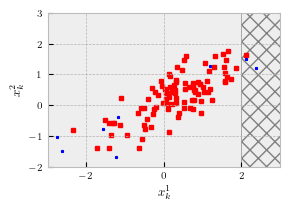

In [19]:

plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])

plt.rc( 'text', usetex=True )

Sigmas11 = np.full((T_horizon,1),np.nan)
x0ps = np.full((T_horizon*n,1),np.nan)
x0pps = np.full((T_horizon,1),np.nan)
Sigmapp0 = var_x0
xpp0 = mu_x0
xpp0_true=np.sqrt(var_x0)@np.random.randn(n,1)+mu_x0
x1_true_rec=np.full((T_horizon,1),np.nan)
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    print(k)
    plt.plot(xpp0[0],xpp0[1],'sr',ms=2.5,zorder=1)
    # Construct the problem.
    Sigmapp1 = F@Sigmapp0@F.T + var_w
    TT, hh = Constraints(F,G,K,T,S,Sigma_x,Sigma_u,xpp0,uBar,xBar,N,epsilon)
    x0p = cp.Variable((n,1))
    objective = cp.Minimize(cp.quad_form(x0p, A1) + 2 * xpp0.T @ A2 @ x0p)
    #hh=hh.reshape(N*(t+m),)
    #constraints = [TT@x0p <= hh]
    
    #constraints += [x0p.T @ I1 @ x0p + xpp0.T @ I2 @ x0p <= c - xpp0.T @ I3 @ xpp0]
    #constraints += [cp.quad_form( x0p, I1 ) + xpp0.T @ I2 @ x0p <= c - xpp0.T @ I3 @ xpp0]
    prob = cp.Problem(objective)#,constraints)#)#, constraints)
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    x0star = x0p.value
    x0ps[range(k*n,(k+1)*n),:] = x0star.reshape(n,1)
    Sigmas11[k,:] = Sigmapp0[0,0]
    x0pps[k,:] = xpp0[0,0]
    x1_true_rec[k,:]=xpp0_true[0]
    u = np.array((K@x0star).reshape(1,1)) + np.array((K@xpp0).reshape(1,1))
    u = -u
    #u = np.array((K@xpp0).reshape(1,1))
    xpp0_true, y1 = trueTraj(xpp0_true,F,G,u,H,var_w,var_v)
    #y1s[k]=y1
    xpp0, Sigmapp0 = KF_1step(y1,var_w,var_v,F,G,H,Sigmapp0,xpp0,u)
    plt.plot(x0star[0]+xpp0[0],x0star[1]+xpp0[1],'*b',ms=2,zorder=2)
    #plt.plot(xpp0_true[0],xpp0_true[1],'.k')
plt.ylim([-2, 3]) 
plt.savefig('figs/LinearStateSelection.pdf',bbox_inches ="tight")
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7) 

plt.show()


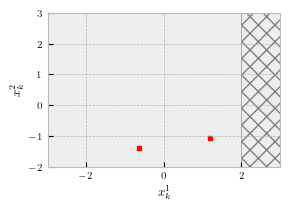

In [11]:
# Plotting
#With particle filter conditional mean
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])
plt.ylim([-2, 3])

# Initialize algorithm
Sigmapp0 = var_x0
xpp0 = mu_x0
xpp0_true=np.sqrt(var_x0)@np.random.randn(n,1)+mu_x0
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    plt.plot(xpp0[0],xpp0[1],'sr',ms=3,zorder=1)
    # Construct the problem.
    u = np.array((K@xpp0).reshape(1,1))
    xpp0_true, y1 = trueTraj(xpp0_true,F,G,u,H,var_w,var_v)
    #y1s[k]=y1
    xpp0, Sigmapp0 = KF_1step(y1,var_w,var_v,F,G,H,Sigmapp0,xpp0,u)
    #plt.plot(xpp0_true[0],xpp0_true[1],'.k')

plt.savefig('figs/LinearStateSpaceLQROnly.pdf',bbox_inches ="tight")
plt.show()


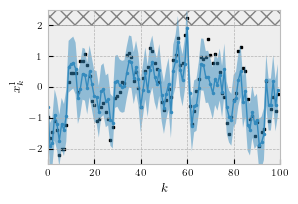

In [12]:
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((-1,2), 200, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)
sigmas=np.sqrt(Sigmas11).reshape(T_horizon,)
k=range(T_horizon)
x=x0pps.reshape(T_horizon,)
nn=2
y1 = x-nn*sigmas
y2 = x+nn*sigmas

# plot
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('$x^1_k$', fontsize=9) 

plt.fill_between(k, y1, y2, alpha=.5, linewidth=0)
plt.plot(k, x, '-o', ms=1.5 , linewidth=1)
plt.plot(k,x1_true_rec,'sk',ms=2,linewidth=1,zorder=0)
plt.xlim([0, 100])
plt.ylim([-2.5, 2.5])
plt.savefig('figs/Linear2Sigmas.pdf',bbox_inches ="tight")
plt.show()